This script extracts the Z-coordinates of two residues of the cytosolic domain of a membrane protein and plots its distribution as a density plot. This is helpful to visualise the conformational free energy landscape of the cytosolic domain, especially when the goal is to find out the membrane association dynamics of specific residues.

In this example, the Z-coordinates of the NZ atom of Lys281 and Ser283 are extracted and taken as the reaction coordinates for the free energy surface (FES). The sampled conformations are then projected along these reaction coordinates.

In [ ]:
# Load the required modules
import MDAnalysis as mda
import numpy as np
from tqdm import tqdm
import pandas as pd

In [ ]:
# Load the structure file and trajectory and create the MDAnalysis Universe

PSF = 'protein.psf' # Assuming the structure file is in the current directory
XTCs = [
    'run1_centered.xtc',
    'run2_centered.xtc',
] # Loading two replicate runs, centered and autoimaged using CPPTRAJ


In [ ]:
# Specify the tip atoms of the residues

tip_atoms = {
    'GLY': 'CA',
    'ALA': 'CB',
    'VAL': 'CG1',
    'LEU': 'CD1',
    'ILE': 'CD',
    'MET': 'CE',
    'CYS': 'SG',
    'PHE': 'CZ',
    'TYR': 'OH',
    # 'TRP': '',
    'HSD': 'NE2',
    'LYS': 'NZ',
    'ARG': 'NH1',
    'ASP': 'OD1',
    'GLU': 'OE1',
    'ASN': 'ND2',
    'GLN': 'NE2',
    'SER': 'OG',
    'THR': 'OG1',
    'PRO': 'CG',
}


In [ ]:
for run, XTC in enumerate(XTCs):
    u = mda.Universe(PSF,XTC)
    protein_CD = u.select_atoms('segid PROA and resid 260 to 290') # Get the cytosolic domain residues (in this example, 260-290)
    protein_CD_tip_atoms = [u.select_atoms(f'segid PROA and resid {res.resid} and name {tip_atoms[res.resname]}', updating=True)
                            for res in protein_CD.residues] # Get the residue tip atoms
    z_coords_all = []
    # Specify the start and end frames of the trajectory and step for analysis
    start=0
    stop=5000
    step=1
    for ts in tqdm(u.trajectory[start:stop:step]):
        z_coords_all.append([atom.positions[0][2] for atom in protein_CD_tip_atoms]) # Extract the Z-coordinates
    
    z_coords_all = np.array(z_coords_all)
    # Create a z-coords directory for storing the npy files
    np.save(f'z_coords/run{run+1}_zcoords_wholeCD.npy', z_coords_all)

In [ ]:
# Now save the extracted Z-coordinates into a pickle file

import pickle
import glob
import numpy as np

combined_array_Zcoords = []
for i in sorted(glob.glob('z_coords/run*_zcoords_wholeCD.npy')):  
    a = np.load(i)
    combined_array_Zcoords.append(a)

pickle.dump(combined_array_Zcoords, open('z_coords/zcoords_wholeCD.pkl','wb'))

# Load the data and plot

In [1]:
import pickle

Z_coords_array = pickle.load(open('../../z_coords/proj03_zcoords_wholeCD.pkl','rb'))
len(Z_coords_array), Z_coords_array[0].shape, Z_coords_array[1].shape

(2, (5045, 31), (5006, 31))

In [2]:
# Extract the residues of interest from the pkl file of Z-coordinates

K281_z = []
S283_z = []

for traj in range(len(Z_coords_array)):
    for frame in range(0, len(Z_coords_array[traj])):
        K281_z.append(Z_coords_array[traj][frame][21]) # Be careful while choosing the index
        S283_z.append(Z_coords_array[traj][frame][23])

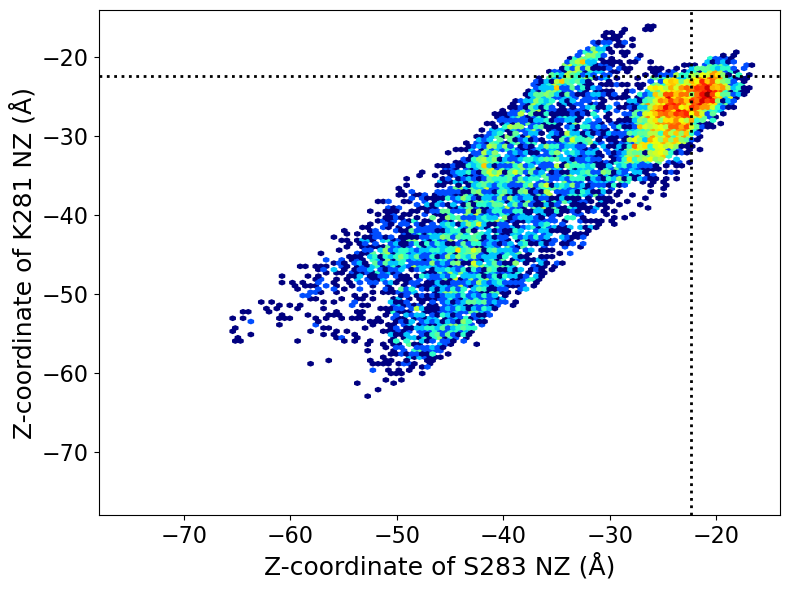

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.hexbin(S283_z,K281_z,gridsize=100,bins='log',cmap='jet',mincnt=1)
plt.xlabel('Z-coordinate of S283 NZ (Å)', fontsize=18)
plt.ylabel('Z-coordinate of K281 NZ (Å)', fontsize=18)
plt.xlim(-78,-14)
plt.ylim(-78,-14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Plot the average phosphate plane of the membrane lower leaflet along the X and Y axes
plt.axvline(x=-22.37, color='k', linestyle=':', linewidth=2) 
plt.axhline(y=-22.37, color='k', linestyle=':', linewidth=2)

plt.tight_layout()
# plt.savefig('FES.png', dpi=600)
plt.show()


Another way to visualise is to plot the density by performing kernel density estimation (KDE) for a smooth distribution.

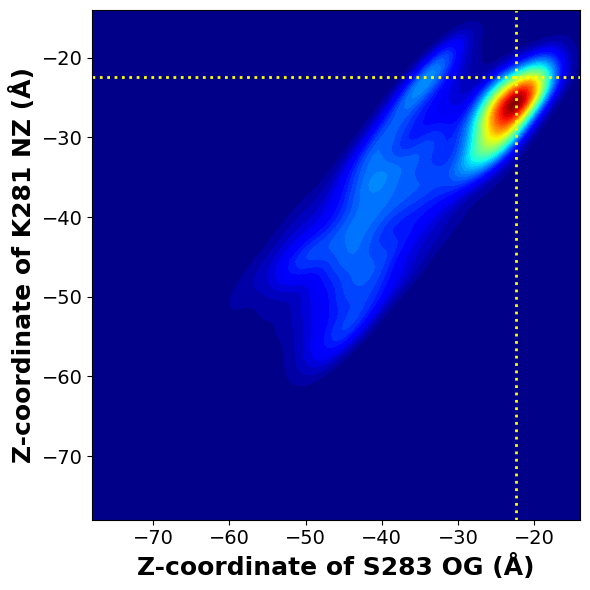

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

start=0
x = S283_z[start:]
y = K281_z[start:]

# Define the grid for the density plot
x_min, x_max = -78, -14
y_min, y_max = -78, -14
x_grid = np.linspace(x_min, x_max, 100)
y_grid = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x_grid, y_grid)

# Perform kernel density estimation (KDE) for a smooth distribution
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x, y])
kde = gaussian_kde(values)
Z = kde(positions).reshape(X.shape)

# Plot the densities
plt.figure(figsize=(6,6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='jet')

# Plot the average phosphate plane of the membrane lower leaflet
plt.axvline(x=-22.37, color='yellow', linestyle=':', linewidth=2)
plt.axhline(y=-22.37, color='yellow', linestyle=':', linewidth=2)

# plt.colorbar(contour, label='Density')

plt.xlabel("Z-coordinate of S283 OG (Å)", fontsize=18, fontweight='bold')
plt.ylabel("Z-coordinate of K281 NZ (Å)", fontsize=18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
# plt.savefig('FES_K281vsS283_Zcoords.png', bbox_inches='tight', dpi=600)

plt.show()
